# PPG Time-Series Dataset: EDA, Cleaning & Visualization

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Styling
PALETTE = {
    'primary':   '#C62828',
    'secondary': '#1565C0',
    'accent':    '#F9A825',
    'positive':  '#2E7D32',
    'bg':        '#FAFAFA',
    'text':      '#212121',
    'pulse':     '#E53935',
    'bp':        '#1E88E5',
}
sns.set_theme(style="whitegrid", font_scale=1.12)
plt.rcParams.update({
    'figure.facecolor': PALETTE['bg'],
    'axes.facecolor':   PALETTE['bg'],
    'axes.edgecolor':   '#BDBDBD',
    'text.color':       PALETTE['text'],
    'font.family':      'DejaVu Sans',
})

DATA_PATH   = '../data/raw/PPG_dataset.csv'
OUTPUT_DIR  = '../reports/figures/'
CLEANED_OUT = '../data/processed/ppg_features_cleaned.csv'

In [15]:
# Loading PPG Dataset
df_raw = pd.read_csv(DATA_PATH)
print(f"Shape        : {df_raw.shape}")
print(f"Columns      : {df_raw.shape[1]} total")
print(f"\nFirst 5 column names: {df_raw.columns[:5].tolist()}")
print(f"Last 5 column names : {df_raw.columns[-5:].tolist()}")

# Identify label column (assumed to be named 'Label' or last column)
if 'Label' in df_raw.columns:
    label_col = 'Label'
elif 'label' in df_raw.columns:
    label_col = 'label'
else:
    label_col = df_raw.columns[-1]
    print(f"\nAssuming last column '{label_col}' is the label.")

print(f"\nLabel column : {label_col}")
print(f"Label distribution:\n{df_raw[label_col].value_counts()}")
print(f"\nNull counts in labels : {df_raw[label_col].isnull().sum()}")

# Separate waveform columns from label
waveform_cols = [c for c in df_raw.columns if c != label_col]
print(f"\nWaveform columns     : {len(waveform_cols)}")
print(f"Data type check      : {df_raw[waveform_cols].dtypes.unique()}")

Shape        : (2576, 2001)
Columns      : 2001 total

First 5 column names: ['0', '1', '2', '3', '4']
Last 5 column names : ['1996', '1997', '1998', '1999', 'Label']

Label column : Label
Label distribution:
Label
MI        1294
Normal    1282
Name: count, dtype: int64

Null counts in labels : 0

Waveform columns     : 2000
Data type check      : [dtype('float64')]


In [19]:
# Waveform Feature Extraction
sample_cols_mask = [c for c in df_raw.columns if c.startswith('sample_')]
df_wave          = df_raw[sample_cols_mask]
SAMPLING_RATE               = 125

def extract_ppg_features(row):
    """Extract temporal & statistical features from one PPG segment."""
    signal  = row.values.astype(float)
    
    # Handling any NaN values in the waveform
    if np.isnan(signal).any():
        signal = np.nan_to_num(signal, nan=0.0)
    
    # Basic stats
    mean_v  = np.mean(signal)
    std_v   = np.std(signal)
    min_v   = np.min(signal)
    max_v   = np.max(signal)
    amp     = max_v - min_v
    
    # Shape characteristics
    skew    = pd.Series(signal).skew()
    kurt    = pd.Series(signal).kurt()
    
    # Zero-crossing rate (rhythm/frequency proxy)
    zero_crossings = np.sum(np.diff(np.sign(signal - mean_v)) != 0)
    zcr     = zero_crossings / len(signal)
    
    # Energy
    energy  = np.sum(signal ** 2) / len(signal)
    
    # Estimate HR from zero-crossing rate
    est_hr  = zcr * SAMPLING_RATE * 30
    
    # Peak count (alternate HR estimate)
    try:
        peaks, _ = find_peaks(signal, distance=SAMPLING_RATE//3)
        peak_count = len(peaks)
        segment_duration = len(signal) / SAMPLING_RATE
        est_hr_peaks = (peak_count / segment_duration) * 60 if segment_duration > 0 else 0
    except:
        peak_count = 0
        est_hr_peaks = 0
    
    return pd.Series({
        'ppg_mean':        mean_v,
        'ppg_std':         std_v,
        'ppg_min':         min_v,
        'ppg_max':         max_v,
        'ppg_amplitude':   amp,
        'ppg_skewness':    skew,
        'ppg_kurtosis':    kurt,
        'ppg_zcr':         zcr,
        'ppg_energy':      energy,
        'ppg_est_hr':      est_hr,
        'ppg_peak_count':  peak_count,
        'ppg_est_hr_peaks': est_hr_peaks,
    })

print(f"Extracting features from {len(df_raw)} waveform segments...")

df_wave_raw = df_raw[waveform_cols]
features_raw = df_wave_raw.apply(extract_ppg_features, axis=1)
features_raw[label_col] = df_raw[label_col].values

print(f"\nFeature extraction complete")
print(f"  Feature shape : {features_raw.shape}")
print(f"  Features      : {[c for c in features_raw.columns if c != label_col]}")
print(f"\nFeature summary (before cleaning):\n{features_raw.describe().round(3)}")


Extracting features from 2576 waveform segments...

Feature extraction complete
  Feature shape : (2576, 13)
  Features      : ['ppg_mean', 'ppg_std', 'ppg_min', 'ppg_max', 'ppg_amplitude', 'ppg_skewness', 'ppg_kurtosis', 'ppg_zcr', 'ppg_energy', 'ppg_est_hr', 'ppg_peak_count', 'ppg_est_hr_peaks']

Feature summary (before cleaning):
       ppg_mean   ppg_std   ppg_min   ppg_max  ppg_amplitude  ppg_skewness  \
count  2576.000  2576.000  2576.000  2576.000       2576.000      2576.000   
mean      0.010     0.433    -0.789     0.742          1.531        -0.041   
std       0.007     0.008     0.143     0.096          0.238         0.030   
min       0.002     0.423    -1.009     0.630          1.260        -0.104   
25%       0.003     0.425    -0.932     0.647          1.296        -0.070   
50%       0.004     0.426    -0.671     0.670          1.329        -0.018   
75%       0.016     0.441    -0.648     0.837          1.770        -0.013   
max       0.022     0.446    -0.630     0

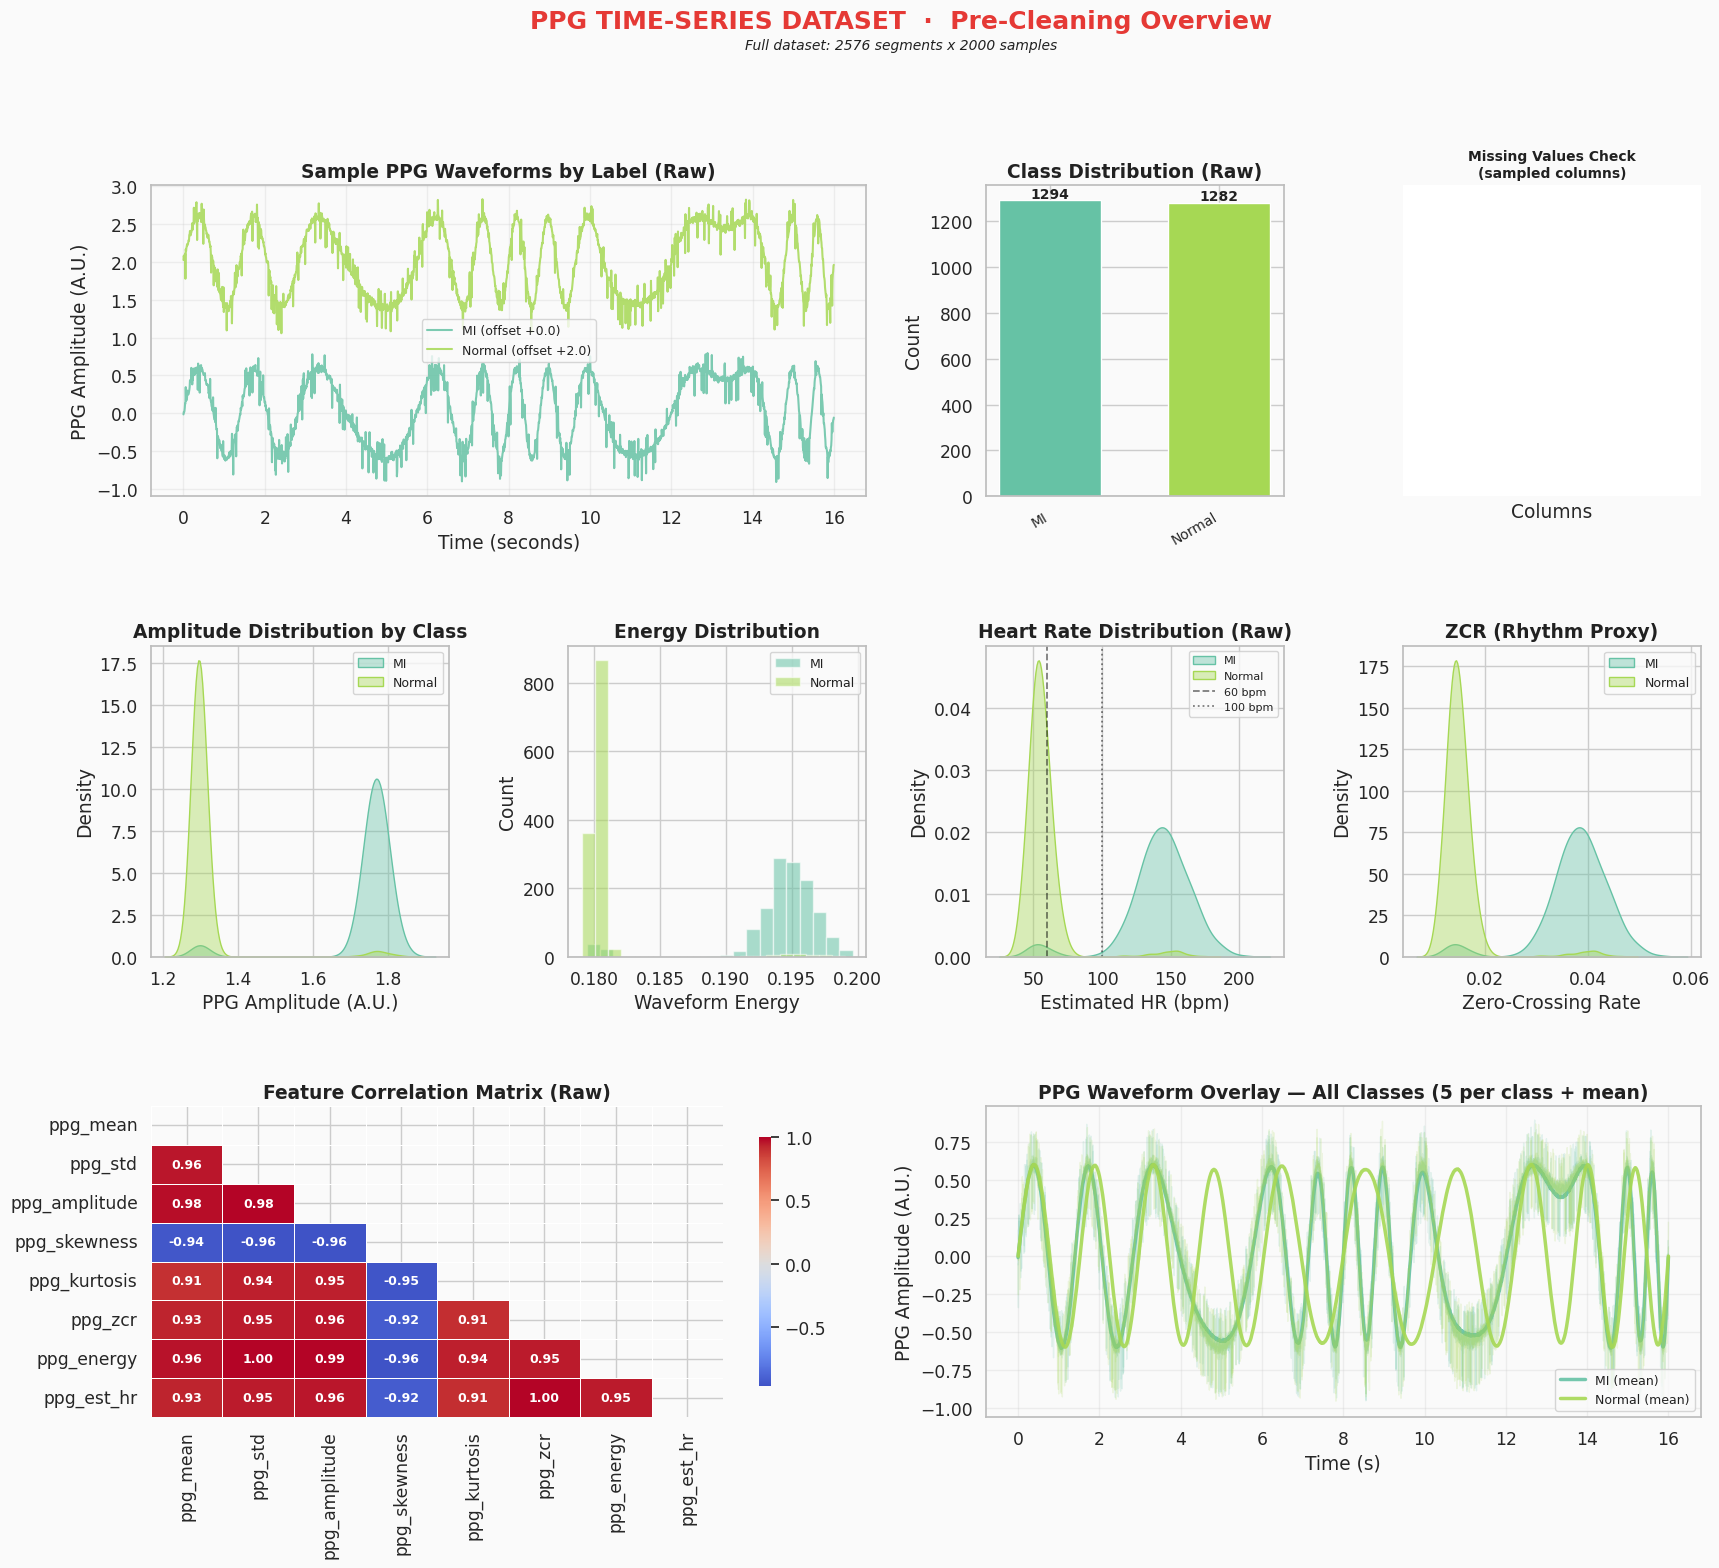

Saved: ppg_pre_cleaning_overview.png


In [21]:
# Pre-cleaning Visualisations

# Create color map for labels
unique_labels = df_raw[label_col].unique()
label_colors  = {
    label: plt.cm.Set2(i / len(unique_labels)) 
    for i, label in enumerate(unique_labels)
}

fig = plt.figure(figsize=(20, 16))
fig.patch.set_facecolor(PALETTE['bg'])
gs  = gridspec.GridSpec(3, 4, figure=fig, hspace=0.48, wspace=0.40)
fig.suptitle('PPG TIME-SERIES DATASET  ·  Pre-Cleaning Overview',
             fontsize=18, fontweight='bold', color=PALETTE['pulse'], y=0.99)
fig.text(0.5, 0.965, f'Full dataset: {len(df_raw)} segments x {len(waveform_cols)} samples',
         ha='center', fontsize=10, color=PALETTE['text'], style='italic')

t_axis = np.linspace(0, len(waveform_cols) / SAMPLING_RATE, len(waveform_cols))

# 1: Sample waveforms by label
ax1 = fig.add_subplot(gs[0, :2])
for i, label in enumerate(list(unique_labels)[:3]):
    subset = df_raw[df_raw[label_col] == label]
    if len(subset) > 0:
        row = subset.iloc[0][waveform_cols].values.astype(float)
        offset = i * 2.0
        ax1.plot(t_axis, row + offset, color=label_colors[label],
                 linewidth=1.5, label=f'{label} (offset +{offset:.1f})', alpha=0.85)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('PPG Amplitude (A.U.)')
ax1.set_title('Sample PPG Waveforms by Label (Raw)', fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 2: Label distribution
ax2 = fig.add_subplot(gs[0, 2])
label_counts = df_raw[label_col].value_counts()
colors2 = [label_colors.get(lbl, PALETTE['secondary']) for lbl in label_counts.index]
bars = ax2.bar(range(len(label_counts)), label_counts.values, color=colors2, edgecolor='white', width=0.6)
ax2.set_xticks(range(len(label_counts)))
ax2.set_xticklabels(label_counts.index, rotation=30, ha='right', fontsize=10)
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution (Raw)', fontweight='bold')
for bar, val in zip(bars, label_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(val), ha='center', fontsize=10, fontweight='bold')

# 3: Missing values heatmap
ax3 = fig.add_subplot(gs[0, 3])
sample_cols = waveform_cols[::len(waveform_cols)//100] if len(waveform_cols) > 100 else waveform_cols
miss_map = df_raw[sample_cols + [label_col]].isnull()
sns.heatmap(miss_map, cbar=False, cmap=['#E8F5E9', PALETTE['primary']],
            ax=ax3, yticklabels=False, xticklabels=False, linewidths=0.1)
ax3.set_title('Missing Values Check\n(sampled columns)', fontweight='bold', fontsize=10)
ax3.set_xlabel('Columns')

# 4: Amplitude distribution by label
ax4 = fig.add_subplot(gs[1, 0])
for label in unique_labels:
    subset = features_raw[features_raw[label_col] == label]['ppg_amplitude']
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax4, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax4.set_xlabel('PPG Amplitude (A.U.)')
ax4.set_title('Amplitude Distribution by Class', fontweight='bold')
ax4.legend(fontsize=9)

# 5: Energy distribution
ax5 = fig.add_subplot(gs[1, 1])
for label in unique_labels:
    subset = features_raw[features_raw[label_col] == label]['ppg_energy']
    if len(subset) > 0:
        ax5.hist(subset, bins=20, alpha=0.55,
                 color=label_colors.get(label, PALETTE['secondary']),
                 label=label, edgecolor='white')
ax5.set_xlabel('Waveform Energy')
ax5.set_ylabel('Count')
ax5.set_title('Energy Distribution', fontweight='bold')
ax5.legend(fontsize=9)

# 6: Estimated HR distribution
ax6 = fig.add_subplot(gs[1, 2])
for label in unique_labels:
    subset = features_raw[features_raw[label_col] == label]['ppg_est_hr']
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax6, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax6.axvline(60,  color='black', linestyle='--', linewidth=1.3, alpha=0.5, label='60 bpm')
ax6.axvline(100, color='black', linestyle=':',  linewidth=1.3, alpha=0.5, label='100 bpm')
ax6.set_xlabel('Estimated HR (bpm)')
ax6.set_title('Heart Rate Distribution (Raw)', fontweight='bold')
ax6.legend(fontsize=8)

# 7: Zero-crossing rate
ax7 = fig.add_subplot(gs[1, 3])
for label in unique_labels:
    subset = features_raw[features_raw[label_col] == label]['ppg_zcr']
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax7, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax7.set_xlabel('Zero-Crossing Rate')
ax7.set_title('ZCR (Rhythm Proxy)', fontweight='bold')
ax7.legend(fontsize=9)

# 8: Raw feature correlation
ax8 = fig.add_subplot(gs[2, :2])
feat_cols_corr = ['ppg_mean', 'ppg_std', 'ppg_amplitude', 'ppg_skewness',
                   'ppg_kurtosis', 'ppg_zcr', 'ppg_energy', 'ppg_est_hr']
corr_raw = features_raw[feat_cols_corr].corr()
mask_raw = np.triu(np.ones_like(corr_raw, dtype=bool))
sns.heatmap(corr_raw, mask=mask_raw, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax8, linewidths=0.4,
            annot_kws={'size': 9, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8})
ax8.set_title('Feature Correlation Matrix (Raw)', fontweight='bold')

# Multi-waveform overlay
ax9 = fig.add_subplot(gs[2, 2:])
for label in unique_labels:
    subset = df_raw[df_raw[label_col] == label]
    for _, row in subset.head(5).iterrows():
        wave = row[waveform_cols].values.astype(float)
        ax9.plot(t_axis, wave, color=label_colors.get(label, PALETTE['secondary']),
                 alpha=0.15, linewidth=1)
    
    if len(subset) > 0:
        mean_wave = subset[waveform_cols].values.astype(float).mean(axis=0)
        ax9.plot(t_axis, mean_wave, color=label_colors.get(label, PALETTE['secondary']),
                 linewidth=2.5, label=f'{label} (mean)', alpha=0.9)

ax9.set_xlabel('Time (s)')
ax9.set_ylabel('PPG Amplitude (A.U.)')
ax9.set_title('PPG Waveform Overlay — All Classes (5 per class + mean)', fontweight='bold')
ax9.legend(fontsize=9)
ax9.grid(alpha=0.3)

plt.savefig(OUTPUT_DIR + 'ppg_pre_cleaning_overview.png',
            dpi=150, bbox_inches='tight')

plt.show()
plt.close()
print("Saved: ppg_pre_cleaning_overview.png")

In [22]:
# Data Cleaning Pipeline
df_features = features_raw.copy()
orig_rows = len(df_features)

# Dropping nulls
null_count = df_features.isnull().sum().sum()
df_features = df_features.dropna()
print(f"Dropping nulls       : {null_count} nulls removed | rows {len(df_features)}")

# Removing duplicates
dup_count = df_features.duplicated().sum()
df_features = df_features.drop_duplicates().reset_index(drop=True)
print(f"Removing duplicates: {dup_count} removed | rows {len(df_features)}")

# Amplitude plausibility check
amp_mask = df_features['ppg_amplitude'].between(0.01, 20.0)
df_features = df_features[amp_mask].reset_index(drop=True)
print(f"Amplitude filter : rows {len(df_features)}")

# Removing extreme outliers
for feat in ['ppg_mean', 'ppg_std', 'ppg_energy']:
    q1 = df_features[feat].quantile(0.01)
    q99 = df_features[feat].quantile(0.99)
    df_features = df_features[df_features[feat].between(q1, q99)]
print(f"Outlier removal  : rows {len(df_features)}")

# Add signal quality index
df_features['sqi'] = (
    1 / (1 + df_features['ppg_std'].clip(lower=1e-6)) *
    df_features['ppg_amplitude'].clip(upper=5) / 5
)
print(f"Signal Quality   : SQI added (mean={df_features['sqi'].mean():.3f})")

# Adding clinical flags
df_features['tachycardia_flag'] = (df_features['ppg_est_hr'] > 100).astype(int)
df_features['bradycardia_flag'] = (df_features['ppg_est_hr'] < 60).astype(int)
print(f"HR flags         : tachy={df_features['tachycardia_flag'].sum()}, brady={df_features['bradycardia_flag'].sum()}")

# Encoding labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_features['label_encoded'] = le.fit_transform(df_features[label_col])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Encode labels    : {label_mapping}")

print(f"\nFinal shape: {df_features.shape}")
print(f"Rows removed: {orig_rows - len(df_features)} ({(orig_rows - len(df_features))/orig_rows*100:.1f}%)")

df_features.to_csv(CLEANED_OUT, index=False)
print(f"Saved - {CLEANED_OUT}")

Dropping nulls       : 0 nulls removed | rows 2576
Removing duplicates: 0 removed | rows 2576
Amplitude filter : rows 2576
Outlier removal  : rows 2422
Signal Quality   : SQI added (mean=0.213)
HR flags         : tachy=1190, brady=911
Encode labels    : {'MI': np.int64(0), 'Normal': np.int64(1)}

Final shape: (2422, 17)
Rows removed: 154 (6.0%)
Saved - ../data/processed/ppg_features_cleaned.csv


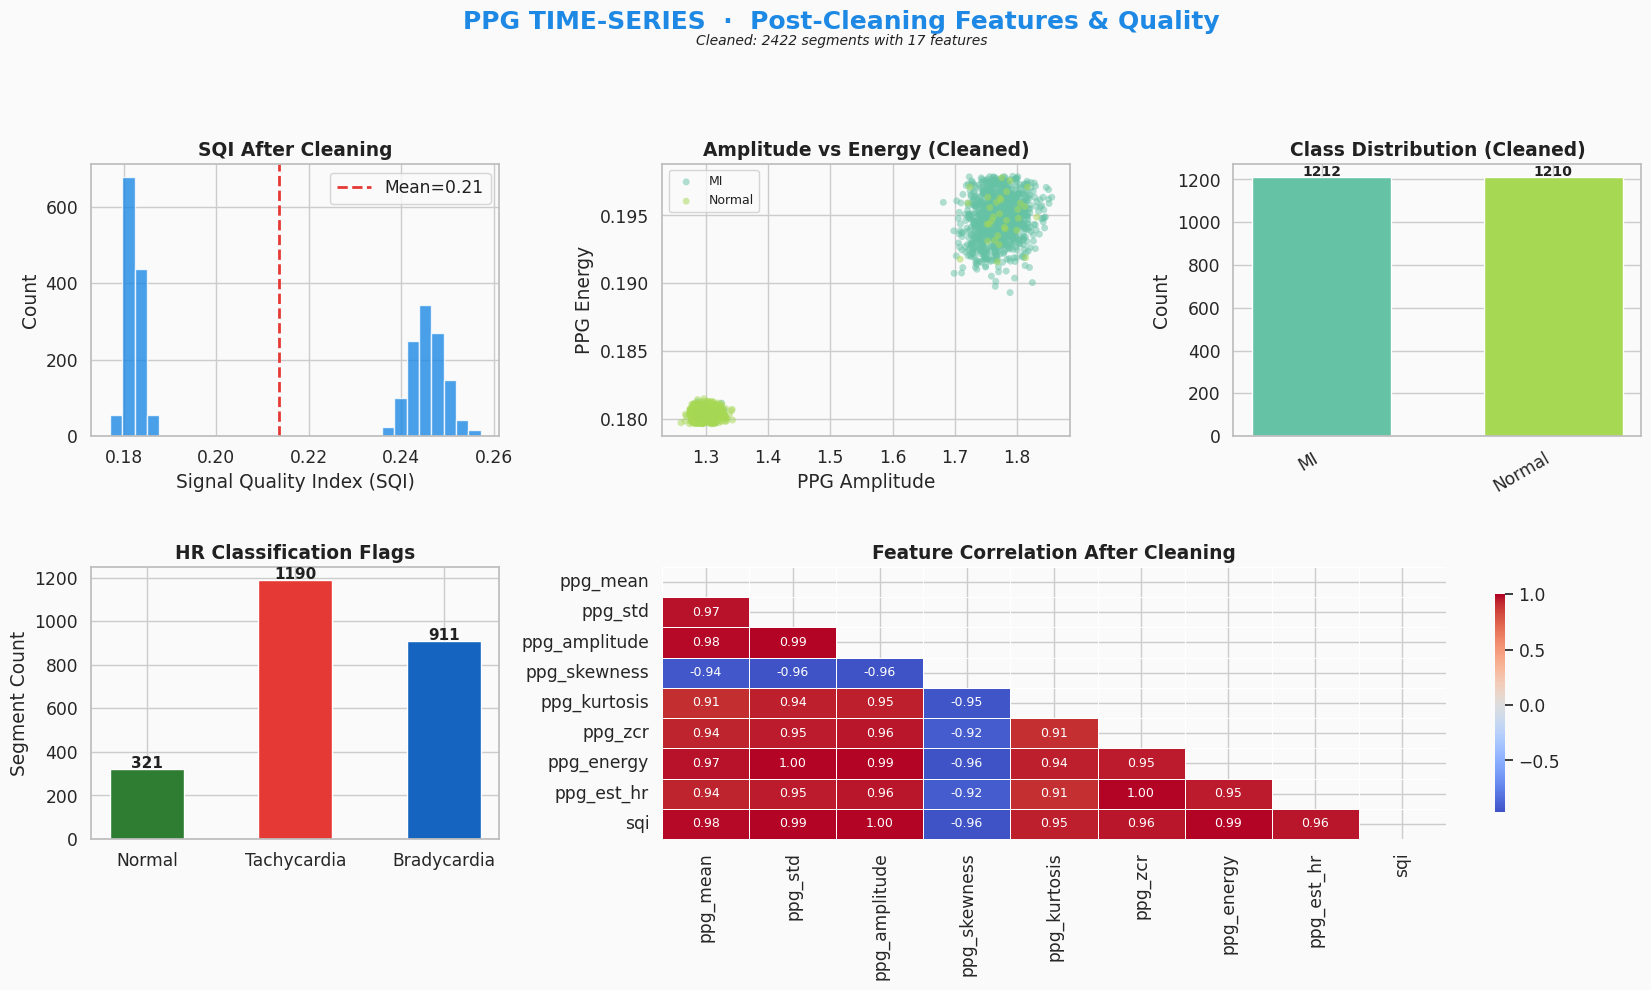

Saved: ppg_post_cleaning_features.png


In [25]:
# Post-Cleaning Visualisations

fig2 = plt.figure(figsize=(20, 14))
fig2.patch.set_facecolor(PALETTE['bg'])
gs2  = gridspec.GridSpec(3, 3, figure=fig2, hspace=0.48, wspace=0.40)
fig2.suptitle('PPG TIME-SERIES  ·  Post-Cleaning Features & Quality',
              fontsize=18, fontweight='bold', color=PALETTE['bp'], y=0.99)
fig2.text(0.5, 0.965, f'Cleaned: {len(df_features)} segments with {df_features.shape[1]} features',
          ha='center', fontsize=10, color=PALETTE['text'], style='italic')

# 1: SQI distribution
ax1 = fig2.add_subplot(gs2[0, 0])
ax1.hist(df_features['sqi'], bins=30, color=PALETTE['bp'], edgecolor='white', alpha=0.8)
ax1.axvline(df_features['sqi'].mean(), color=PALETTE['pulse'], linestyle='--',
            linewidth=2, label=f"Mean={df_features['sqi'].mean():.2f}")
ax1.set_xlabel('Signal Quality Index (SQI)')
ax1.set_ylabel('Count')
ax1.set_title('SQI After Cleaning', fontweight='bold')
ax1.legend()

# 2: Amplitude vs Energy
ax2 = fig2.add_subplot(gs2[0, 1])
for label in unique_labels:
    subset = df_features[df_features[label_col] == label]
    if len(subset) > 0:
        ax2.scatter(subset['ppg_amplitude'], subset['ppg_energy'],
                    c=label_colors.get(label, PALETTE['secondary']),
                    alpha=0.5, s=25, label=label, edgecolors='none')
ax2.set_xlabel('PPG Amplitude')
ax2.set_ylabel('PPG Energy')
ax2.set_title('Amplitude vs Energy (Cleaned)', fontweight='bold')
ax2.legend(fontsize=9)

# 3: Class distribution
ax3 = fig2.add_subplot(gs2[0, 2])
clean_counts = df_features[label_col].value_counts()
colors3 = [label_colors.get(lbl, PALETTE['secondary']) for lbl in clean_counts.index]
bars3 = ax3.bar(range(len(clean_counts)), clean_counts.values, color=colors3, edgecolor='white', width=0.6)
ax3.set_xticks(range(len(clean_counts)))
ax3.set_xticklabels(clean_counts.index, rotation=30, ha='right')
ax3.set_ylabel('Count')
ax3.set_title('Class Distribution (Cleaned)', fontweight='bold')
for bar, val in zip(bars3, clean_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(val), ha='center', fontsize=10, fontweight='bold')

# 4: HR flags
ax4 = fig2.add_subplot(gs2[1, 0])
flag_data = {
    'Normal': (~df_features['tachycardia_flag'].astype(bool) & ~df_features['bradycardia_flag'].astype(bool)).sum(),
    'Tachycardia': df_features['tachycardia_flag'].sum(),
    'Bradycardia': df_features['bradycardia_flag'].sum(),
}
bars4 = ax4.bar(flag_data.keys(), flag_data.values(),
                color=[PALETTE['positive'], PALETTE['pulse'], PALETTE['secondary']],
                edgecolor='white', width=0.5)
for bar in bars4:
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(int(bar.get_height())), ha='center', fontsize=11, fontweight='bold')
ax4.set_ylabel('Segment Count')
ax4.set_title('HR Classification Flags', fontweight='bold')

# 5: Feature correlation
ax5 = fig2.add_subplot(gs2[1, 1:])
clean_feat = ['ppg_mean', 'ppg_std', 'ppg_amplitude', 'ppg_skewness',
              'ppg_kurtosis', 'ppg_zcr', 'ppg_energy', 'ppg_est_hr', 'sqi']
corr_clean = df_features[clean_feat].corr()
mask_clean = np.triu(np.ones_like(corr_clean, dtype=bool))
sns.heatmap(corr_clean, mask=mask_clean, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax5, linewidths=0.4,
            annot_kws={'size': 9},
            cbar_kws={'shrink': 0.8})
ax5.set_title('Feature Correlation After Cleaning', fontweight='bold')

plt.savefig(OUTPUT_DIR + 'ppg_post_cleaning_features.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("Saved: ppg_post_cleaning_features.png")

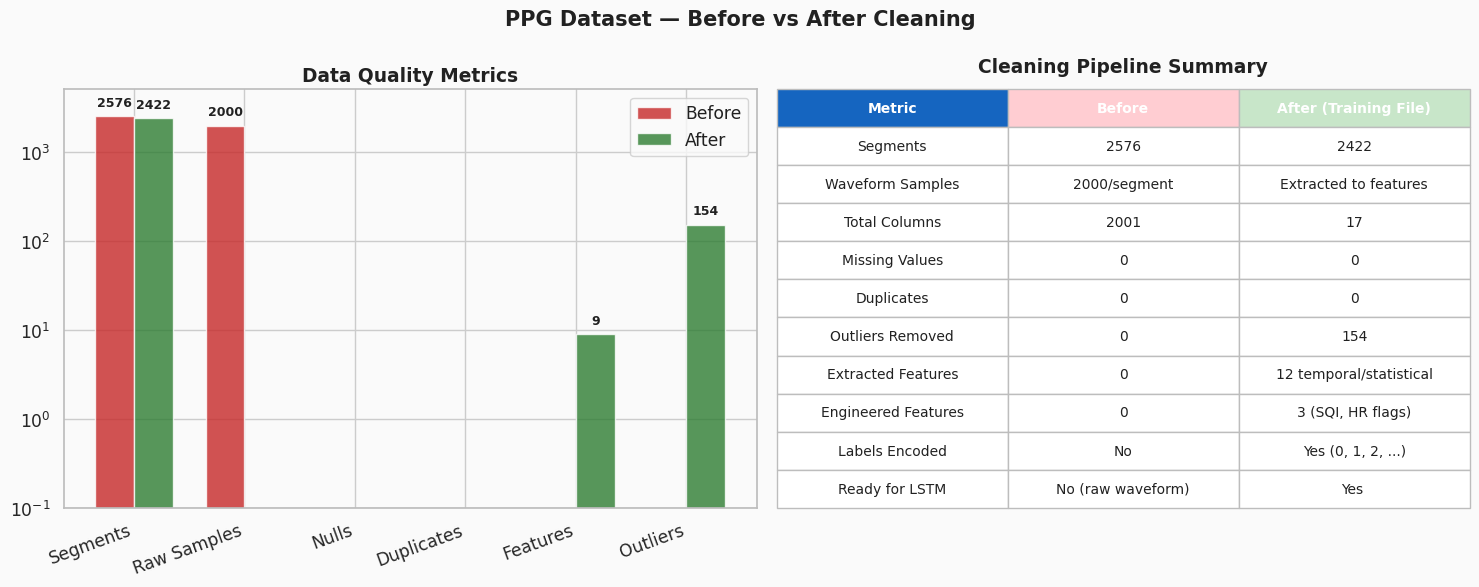

Saved: ppg_before_after_summary.png


In [ ]:
# BEFORE vs AFTER Comparison Summary
fig3, axes3 = plt.subplots(1, 2, figsize=(15, 6))
fig3.patch.set_facecolor(PALETTE['bg'])
fig3.suptitle('PPG Dataset — Before vs After Cleaning',
              fontsize=15, fontweight='bold')

# Left: bar comparison
metrics_b = {
    'Segments': len(df_raw),
    'Raw Samples': len(waveform_cols),
    'Nulls': df_raw.isnull().sum().sum(),
    'Duplicates': df_raw.duplicated().sum(),
    'Features': 0,
    'Outliers': 0,
}
metrics_a = {
    'Segments': len(df_features),
    'Raw Samples': 0,  # Converted to features
    'Nulls': 0,
    'Duplicates': 0,
    'Features': len(clean_feat),
    'Outliers': orig_rows - len(df_features),
}

x3 = np.arange(len(metrics_b))
w3 = 0.35
ax_l = axes3[0]
b1 = ax_l.bar(x3 - w3/2, list(metrics_b.values()), w3, label='Before',
              color=PALETTE['primary'], alpha=0.8, edgecolor='white')
b2 = ax_l.bar(x3 + w3/2, list(metrics_a.values()), w3, label='After',
              color=PALETTE['positive'], alpha=0.8, edgecolor='white')
ax_l.set_xticks(x3)
ax_l.set_xticklabels(list(metrics_b.keys()), rotation=20, ha='right')
ax_l.set_title('Data Quality Metrics', fontweight='bold')
ax_l.legend()
# Using log scale since raw samples (2000) vs features (12) differ greatly
ax_l.set_yscale('log')
ax_l.set_ylim(0.1, max(len(waveform_cols), len(df_raw)) * 2)
for bar in list(b1) + list(b2):
    h = bar.get_height()
    if h > 0:
        ax_l.text(bar.get_x() + bar.get_width()/2, h * 1.3,
                  str(int(h)), ha='center', fontsize=9, fontweight='bold')

# Right: summary table
table_data = [
    ['Metric',              'Before',           'After (Training File)'],
    ['Segments',            str(len(df_raw)),   str(len(df_features))],
    ['Waveform Samples',    '2000/segment',     'Extracted to features'],
    ['Total Columns',       str(df_raw.shape[1]), str(df_features.shape[1])],
    ['Missing Values',      str(df_raw.isnull().sum().sum()), '0'],
    ['Duplicates',          str(df_raw.duplicated().sum()),   '0'],
    ['Outliers Removed',    '0',                str(orig_rows - len(df_features))],
    ['Extracted Features',  '0',                '12 temporal/statistical'],
    ['Engineered Features', '0',                '3 (SQI, HR flags)'],
    ['Labels Encoded',      'No',               'Yes (0, 1, 2, ...)'],
    ['Ready for LSTM',      'No (raw waveform)','Yes'],
]
axes3[1].axis('off')
tbl3 = axes3[1].table(
    cellText=table_data[1:], colLabels=table_data[0],
    cellLoc='center', loc='center',
    colColours=[PALETTE['secondary'], '#FFCDD2', '#C8E6C9'],
    bbox=[0.0, 0.0, 1.0, 1.0]
)
tbl3.auto_set_font_size(False)
tbl3.set_fontsize(10)
for key, cell in tbl3.get_celld().items():
    cell.set_edgecolor('#BDBDBD')
    if key[0] == 0:
        cell.set_text_props(color='white', fontweight='bold')
axes3[1].set_title('Cleaning Pipeline Summary', fontweight='bold', pad=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'ppg_before_after_summary.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print(f"Saved: ppg_before_after_summary.png")